In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AdditiveAttention
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
from PIL import Image
import matplotlib.pyplot as plt
import zipfile

In [ ]:
# Step 1: Create directories
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/augmented_data', exist_ok=True)

# Extract zip files
zip_files = ['akiec.zip', 'df.zip', 'vasc.zip']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/content/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall('/content/data')

In [ ]:
# Step 2: Generate and save augmented images
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

num_aug_per_image = 5

for class_name in os.listdir('/content/data'):
    class_path = os.path.join('/content/data', class_name)
    aug_class_path = os.path.join('/content/augmented_data', class_name)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in augmentation_datagen.flow(x, batch_size=1):
                    aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                    aug_img.save(os.path.join(aug_class_path, f'aug_{i}_{img_name}'))
                    i += 1
                    if i >= num_aug_per_image:
                        break

In [ ]:
# Step 3: Create combined data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1043 images belonging to 3 classes.
Found 259 images belonging to 3 classes.


In [ ]:
# Step 3: Load InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Apply Attention Mechanism After Every Convolutional Layer in InceptionV3
x = base_model.output

# Attention mechanism on the feature map
attention = AdditiveAttention()([x, x])  # Self-attention on final feature map

# Global Average Pooling
x = GlobalAveragePooling2D()(attention)

# Fully Connected Layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final Output Layer
predictions = Dense(3, activation='softmax')(x)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Build and compile model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Set up checkpoints and history callback
checkpoint = ModelCheckpoint('/content/vgg19_model_skin.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

history = History()

In [ ]:
# Step 6: Train Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, history]
)

# Step 7: Save Final Model
model.save('/content/vgg19_model_skin_final.h5')
print("Final model saved successfully.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.3377 - loss: 1.3429
Epoch 1: val_loss improved from inf to 1.00837, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 978ms/step - accuracy: 0.3386 - loss: 1.3409 - val_accuracy: 0.5869 - val_loss: 1.0084
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4628 - loss: 1.0971
Epoch 2: val_loss improved from 1.00837 to 0.94128, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.4630 - loss: 1.0963 - val_accuracy: 0.6100 - val_loss: 0.9413
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5075 - loss: 1.0005
Epoch 3: val_loss improved from 0.94128 to 0.86138, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.5082 - loss: 0.9993 - val_accuracy: 0.6139 - val_loss: 0.8614
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5694 - loss: 0.9333
Epoch 4: val_loss improved from 0.86138 to 0.78909, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.5696 - loss: 0.9319 - val_accuracy: 0.6641 - val_loss: 0.7891
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6463 - loss: 0.7799
Epoch 5: val_loss improved from 0.78909 to 0.77862, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.6468 - loss: 0.7793 - val_accuracy: 0.6139 - val_loss: 0.7786
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6728 - loss: 0.7584
Epoch 6: val_loss improved from 0.77862 to 0.74910, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.6729 - loss: 0.7578 - val_accuracy: 0.6564 - val_loss: 0.7491
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7385 - loss: 0.6585
Epoch 7: val_loss improved from 0.74910 to 0.73111, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.7387 - loss: 0.6578 - val_accuracy: 0.6718 - val_loss: 0.7311
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7574 - loss: 0.5961
Epoch 8: val_loss improved from 0.73111 to 0.69249, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.7575 - loss: 0.5958 - val_accuracy: 0.6873 - val_loss: 0.6925
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7670 - loss: 0.5806
Epoch 9: val_loss improved from 0.69249 to 0.66064, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.7675 - loss: 0.5796 - val_accuracy: 0.7220 - val_loss: 0.6606
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8079 - loss: 0.4950
Epoch 10: val_loss did not improve from 0.66064
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.8081 - loss: 0.4949 - val_accuracy: 0.6873 - val_loss: 0.6846
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8038 - loss: 0.4866
Epoch 11: val_loss did not improve from 0.66064
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.8041 - loss: 0.4860 - val_accuracy: 0.7104 - val_loss: 0.6863
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8330 - loss: 0.4543
Epoch 12: val_loss improved from 0.66064 to 0.63719, saving model to /content/vgg19_model_skin.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.8330 - loss: 0.4540 - val_accuracy: 0.7375 - val_loss: 0.6372
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8334 - loss: 0.4222
Epoch 13: val_loss did not improve from 0.63719
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.8336 - loss: 0.4219 - val_accuracy: 0.7336 - val_loss: 0.6448
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8653 - loss: 0.3934
Epoch 14: val_loss did not improve from 0.63719
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.8654 - loss: 0.3931 - val_accuracy: 0.7375 - val_loss: 0.6601
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8673 - loss: 0.3623
Epoch 15: val_loss did not improve from 0.63719
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.8671 - loss: 0.3626 - val_accuracy: 0.7413 - val_loss: 0.6820
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8899 - loss: 0.3344
Epoch 16: val_loss did not improve

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.8919 - loss: 0.3155 - val_accuracy: 0.7606 - val_loss: 0.6237
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8994 - loss: 0.2774
Epoch 18: val_loss did not improve from 0.62366
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.8995 - loss: 0.2776 - val_accuracy: 0.7490 - val_loss: 0.7460
Epoch 19/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9051 - loss: 0.2708
Epoch 19: val_loss did not improve from 0.62366
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.9050 - loss: 0.2709 - val_accuracy: 0.7413 - val_loss: 0.7139
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9019 - loss: 0.2791
Epoch 20: val_loss did not improve from 0.62366
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9017 - loss: 0.2793 - val_accuracy: 0.7413 - val_loss: 0.7477
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9218 - loss: 0.2455
Epoch 21: val_loss did not improve

Final model saved successfully.


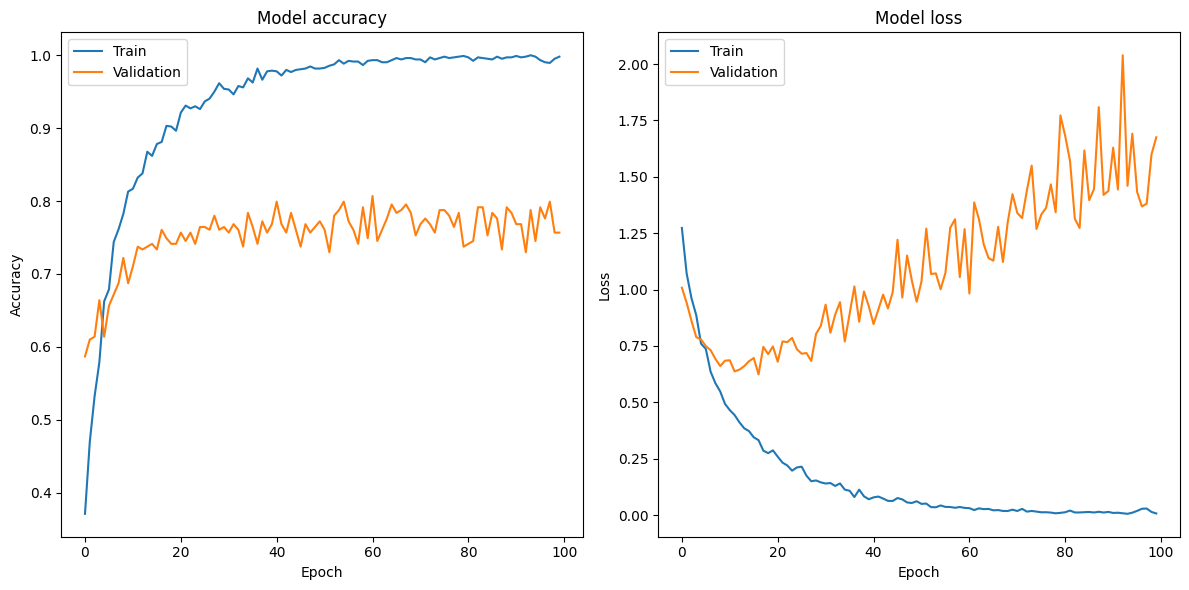

In [ ]:
# Step 8: Plotting accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

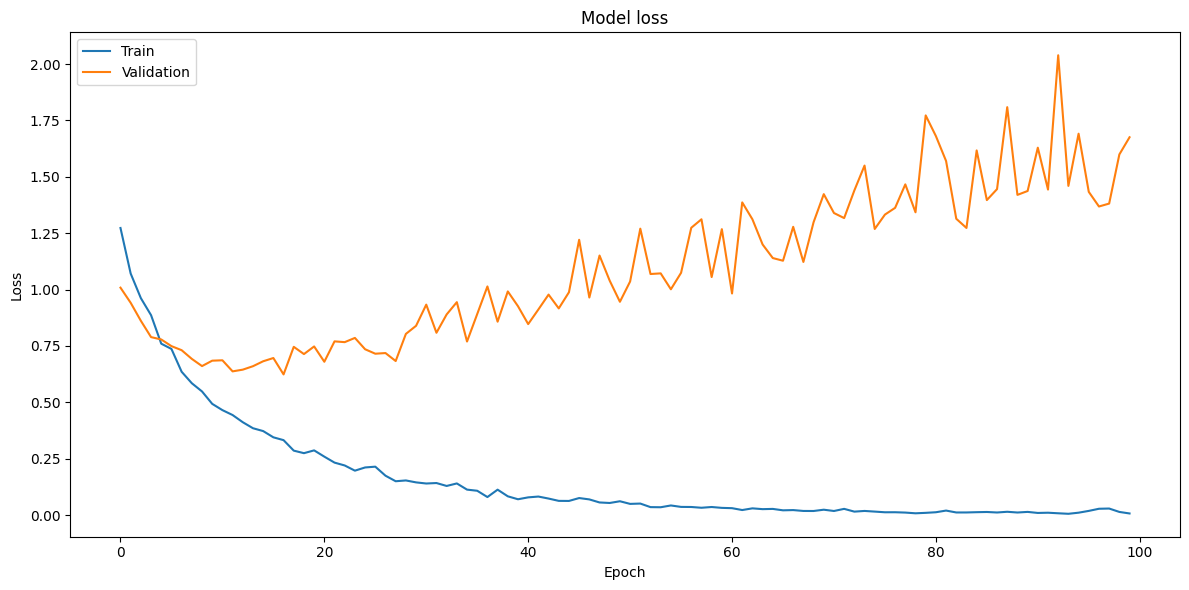

In [ ]:
# Step 9: Plotting loss only graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()